In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

# from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP, MLP
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

import numpy as np
import copy 
import time
from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import trange
from scipy.sparse.csgraph import connected_components
import pickle
import os


In [2]:
import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import argparse
"""
Dataset arguments
"""
parser = argparse.ArgumentParser(
    description='Training GCN on Large-scale Graph Datasets')
parser.add_argument('--dataset', type=str, default='cora',
                    help='Dataset name: pubmed/flickr/reddit/ppi-large')
parser.add_argument('--method', type=str, default='GCN/ResGCN/GCNII', # SGC/GCN/GCNBias/ResGCN/GCNII/APPNP
                    help='Algorithms: seperate using slash')
parser.add_argument('--nhid', type=int, default=64,
                    help='Hidden state dimension')
parser.add_argument('--epoch_num', type=int, default=200,
                    help='Number of Epoch')
parser.add_argument('--batch_size', type=int, default=2000,
                    help='size of output node in a batch')
parser.add_argument('--n_layers', type=int, default=2,
                    help='Number of GCN layers')
parser.add_argument('--dropout', type=float, default=0,
                    help='Dropout rate')
parser.add_argument('--cuda', type=int, default=0,
                    help='Avaiable GPU ID')
args = parser.parse_args()
print(args)

method = args.method.split('/')

"""
Prepare devices
"""
if args.cuda != -1:
    device = torch.device("cuda:" + str(args.cuda))
else:
    device = torch.device("cpu")
    
if args.dataset not in ['cora', 'citeseer', 'pubmed']:
    temp_data = load_data(args.dataset) 
else:
    temp_data = load_data_gcn(args.dataset)

adj_full, adj_train, feat_data, labels, role = process_graph_data(*temp_data)

train_nodes = np.array(role['tr'])
valid_nodes = np.array(role['va'])
test_nodes = np.array(role['te'])

data_loader = DataLoader(adj_full, train_nodes, valid_nodes, test_nodes, device)

Namespace(batch_size=2000, cuda=0, dataset='cora', dropout=0, epoch_num=200, method='GCN/ResGCN/GCNII', n_layers=2, nhid=64)


In [3]:
"""
Setup datasets and models for training (multi-class use sigmoid+binary_cross_entropy, use softmax+nll_loss otherwise)
"""

if args.dataset in ['flickr', 'reddit', 'cora', 'citeseer', 'pubmed']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.LongTensor(labels.argmax(1))
    num_classes = labels_th.max().item()+1
    criterion = nn.CrossEntropyLoss()
    multi_class=False
elif args.dataset in ['ppi', 'ppi-large', 'amazon', 'yelp']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.FloatTensor(labels)
    num_classes = labels_th.shape[1]
    criterion = nn.BCEWithLogitsLoss()
    multi_class=True

feat_data_th = feat_data_th.to(device)
labels_th = labels_th.to(device)

In [4]:
from collections import OrderedDict
def copy_model(model):
    state_dict = {k:v.to('cpu') for k, v in model.named_parameters()}
    state_dict = OrderedDict(state_dict)
    return state_dict
def copy_grad(model):
    state_dict = {k:v.grad.to('cpu') for k, v in model.named_parameters()}
    state_dict = OrderedDict(state_dict)
    return state_dict

In [5]:


# def get_weight_grad_norms(state_dicts_w, state_dicts_g):
#     grad_div_weight = []
#     for i in range(1,len(state_dicts_w)):
#         prev_model = state_dicts_w[i-1]
#         curt_model = state_dicts_w[i]
        
#         pred_grads = state_dicts_g[i-1]
#         curt_grads = state_dicts_g[i]

#         weight_norms_sum = 0
#         for (n1, p1), (n2, p2) in zip(prev_model.items(), curt_model.items()):
#             weight_norms_sum += (p1-p2).norm(2).pow(2).item()

#         grad_norms_sum = 0
#         for (n1, p1), (n2, p2) in zip(prev_grads.items(), curt_grads.items()):
#             grad_norms_sum += (p1-p2).norm(2).pow(2).item()
            
#         grad_div_weight.append(grad_norms_sum/weight_norms_sum)
#     return grad_div_weight



# def get_grad_norms(state_dicts):
#     grad_norms_list = []
#     for i in range(len(state_dicts)):
#         curt_model = state_dicts[i]

#         grad_norms = {}
#         grad_norms_sum = 0
#         for (n1, p1)in curt_model.items():
#             grad_norms[n1] = p1.norm(2).item()
#             grad_norms_sum += p1.norm(2).pow(2).item()
#         grad_norms['all_params'] = np.sqrt(grad_norms_sum)
#         grad_norms_list.append(grad_norms)
#     return grad_norms_list

# def get_weight_norms(state_dicts):
#     weight_norms_list = []
#     for i in range(len(state_dicts)):
#         curt_model = state_dicts[i]

#         weight_norms = {}
#         weight_norms_sum = 0
#         for (n1, p1)in curt_model.items():
#             weight_norms[n1] = p1.norm(2).item()
#             weight_norms_sum += p1.norm(2).pow(2).item()
#         weight_norms['all_params'] = np.sqrt(weight_norms_sum)
#         weight_norms_list.append(weight_norms)
#     return weight_norms_list

In [6]:
def compute_constants(model):
    model.to(device)
    mini_batch, adj  = data_loader.get_train_batch()

    prev_model = copy_model(model)
    output = model(feat_data_th, adj)
    loss = model.criterion(output[mini_batch], labels_th[mini_batch])
    model.zero_grad()
    loss.backward()
    prev_grads = copy_grad(model)
    prev_loss = loss.item()

    for p in model.parameters():
        p.data = p.data - 0.1*p.grad.data

    curt_model = copy_model(model)
    output = model(feat_data_th, adj)
    loss = model.criterion(output[mini_batch], labels_th[mini_batch])
    model.zero_grad()
    loss.backward()
    curt_grads = copy_grad(model)
    curt_loss = loss.item()
    
    weight_norms_sum = 0
    for (n1, p1), (n2, p2) in zip(prev_model.items(), curt_model.items()):
        weight_norms_sum += (p1-p2).norm(2).pow(2).item()
    weight_norms_sum = np.sqrt(weight_norms_sum)

    grad_norms_sum = 0
    for (n1, p1), (n2, p2) in zip(prev_grads.items(), curt_grads.items()):
        grad_norms_sum += (p1-p2).norm(2).pow(2).item()
    grad_norms_sum = np.sqrt(grad_norms_sum)
            
    # output_norm_diff = (prev_output- curt_output).norm(2)
    loss_diff = np.abs(prev_loss - curt_loss)
    # print(grad_norms_sum/weight_norms_sum, loss_diff/weight_norms_sum)
    return grad_norms_sum/weight_norms_sum, loss_diff/weight_norms_sum

In [7]:
def model_init(model):
    for n, p in model.named_parameters():
        if 'gcs' in n:
            # print(n, p.data.norm(2))
            p.data = p.data * 2
            
def get_sigval(model):
    for n, p in model.named_parameters():
        if 'weight' in n:
            _, val, _ = torch.svd(p.data)
            print(n, val.mean(), val.max(), val.min())

In [8]:
class GCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion):
        from layers import GraphConv
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion

    def forward(self, x, adj):
        x = self.linear_in(x)
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
            x = self.relu(x)
            x = self.dropout(x)
        x = self.linear_out(x)
        return x
    
class ResGCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion):
        from layers import GraphConv
        super(ResGCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion

    def forward(self, x, adj):
        x = self.linear_in(x)
        for ell in range(len(self.gcs)):
            x_res = x.clone()
            x = self.gcs[ell](x, adj)
            x = self.relu(x)
            x = self.dropout(x) + x_res
        x = self.linear_out(x)
        return x
    
class GCNII(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion):
        from layers import GCNIILayer
        super(GCNII, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GCNIILayer(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion

    def get_alpha_beta(self, ell):
        alpha = 0.8
        beta = 0.8
        return alpha, beta
    
    def forward(self, x, adj):
        x = self.linear_in(x)
        x_0 = x.clone()
        for ell in range(len(self.gcs)):
            alpha, beta = self.get_alpha_beta(ell)
            x = self.gcs[ell](x, adj, x_0, alpha, beta)
            x = self.relu(x)
            x = self.dropout(x)
        x = self.linear_out(x)
        return x

In [9]:
# model = GCN(n_feat=feat_data.shape[1], 
#                         n_hid=args.nhid, 
#                         n_classes=num_classes, 
#                         n_layers=2, 
#                         dropout=args.dropout, 
#                         criterion=criterion)
# get_sigval(model)

# compute Lipschitz and smoothness constant

In [10]:

methods = ['GCN', 'ResGCN', 'GCNII']
results_dict=dict()
for layer in range(2, 11):
    if 'GCN' in methods:
        curt_result_list = []
        for repeat in range(20):
            model = GCN(n_feat=feat_data.shape[1], 
                        n_hid=args.nhid, 
                        n_classes=num_classes, 
                        n_layers=layer, 
                        dropout=args.dropout, 
                        criterion=criterion)
            model_init(model)
            curt_result_list.append(compute_constants(model))
        results_dict['GCN-L%d'%layer] = np.array(curt_result_list)

    if 'ResGCN' in methods:
        curt_result_list = []
        for repeat in range(20):
            model = ResGCN(n_feat=feat_data.shape[1], 
                        n_hid=args.nhid, 
                        n_classes=num_classes, 
                        n_layers=layer, 
                        dropout=args.dropout, 
                        criterion=criterion)
            model_init(model)
            curt_result_list.append(compute_constants(model))
        results_dict['ResGCN-L%d'%layer] = np.array(curt_result_list)

    if 'GCNII' in methods:
        curt_result_list = []
        for repeat in range(20):
            model = GCNII(n_feat=feat_data.shape[1], 
                        n_hid=args.nhid, 
                        n_classes=num_classes, 
                        n_layers=layer, 
                        dropout=args.dropout, 
                        criterion=criterion)
            model_init(model)
            curt_result_list.append(compute_constants(model))
        results_dict['GCNII-L%d'%layer] = np.array(curt_result_list)

In [11]:
plt.rcParams["figure.figsize"] = (10,3)

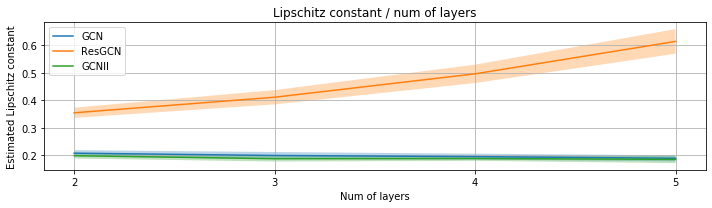

In [12]:
fig, axs = plt.subplots()

for method in ['GCN', 'ResGCN', 'GCNII']:
    mean_list = []
    std_list = []
    for layer in range(2, 6):
        result = results_dict['%s-L%d'%(method, layer)]
        mean, std = np.mean(result, axis=0), np.std(result, axis=0)
        mean_list.append(mean)
        std_list.append(std)
        
    y_vals = np.array(mean_list)[:, 1]
    y_stds = np.array(std_list)[:, 1]
    x_vals = np.arange(len(y_vals))+2
    axs.plot(x_vals, y_vals, label=method)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)
    
# plt.ylim(0.1,1)

plt.title('Lipschitz constant / num of layers')
axs.set_xlabel('Num of layers')
axs.set_ylabel('Estimated Lipschitz constant')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.legend()
plt.savefig('estimated_constant_lip.pdf')

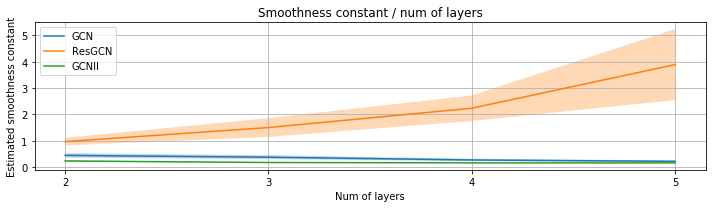

In [13]:
fig, axs = plt.subplots()

for method in ['GCN', 'ResGCN', 'GCNII']:
    mean_list = []
    std_list = []
    for layer in range(2, 6):
        result = results_dict['%s-L%d'%(method, layer)]
        mean, std = np.mean(result, axis=0), np.std(result, axis=0)
        mean_list.append(mean)
        std_list.append(std)
        
    y_vals = np.array(mean_list)[:, 0]
    y_stds = np.array(std_list)[:, 0]
    x_vals = np.arange(len(y_vals))+2
    axs.plot(x_vals, y_vals, label=method)
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

plt.title('Smoothness constant / num of layers')
axs.set_xlabel('Num of layers')
axs.set_ylabel('Estimated smoothness constant')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.legend()
plt.savefig('estimated_constant_smooth.pdf')

In [ ]:
np.